In [94]:
from typing import Dict, Callable
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick
from matplotlib.patches import Patch
import seaborn as sns

In [3]:
world_bank_data = pd.read_excel('P_Data_Extract_From_World_Development_Indicators.xlsx')

In [49]:
year_start = 1991
year_end = 2019
# gdp_measure = 'NY.GDP.PCAP.KD'
# gdp_measure = 'NY.GDP.PCAP.CD'
# gdp_measure = 'NY.GDP.PCAP.PP.KD'
gdp_measure = 'NY.GDP.PCAP.PP.CD'
pop_measure = 'SP.POP.TOTL'

In [57]:
gdp_label = \
    world_bank_data\
        .query(f'`Series Code` == "{gdp_measure}"')\
        ['Series Name']\
        .unique()\
        [0]
gdp_label

'GDP per capita, PPP (current international $)'

In [51]:
def year_column(year: int) -> str:
    return f'{year} [YR{year}]'
gdp = {}
pop = {}
gdp[str(year_start)] = \
    world_bank_data\
        .query(f'`Series Code` == "{gdp_measure}"')\
        [['Country Name', 'Country Code', year_column(year_start)]]
gdp[str(year_end)] = \
    world_bank_data\
        .query(f'`Series Code` == "{gdp_measure}"')\
        [['Country Name', 'Country Code', year_column(year_end)]]
pop[str(year_start)] = \
    world_bank_data\
        .query(f'`Series Code` == "{pop_measure}"')\
        [['Country Name', 'Country Code', year_column(year_start)]]
pop[str(year_end)] = \
    world_bank_data\
        .query(f'`Series Code` == "{pop_measure}"')\
        [['Country Name', 'Country Code', year_column(year_end)]]


## Replicate the Economist Analysis

In [52]:
query_territories = '`Country Code`.isin(["TEA", "TEC", "TLA", "TMN", "TSA", "TSS"])'
query_economist = '`Country Code`.isin(["USA", "JPN", "CHN", "FRA", "DEU", "GBR", "AUT", "ESP", "LUX", "ITA", "IRL"])'

In [133]:
def group_economist(country_code: str) -> str:
    if country_code in ["FRA", "DEU", "GBR", "AUT", "ESP", "LUX", "ITA", "IRL",]:
        return "Western Europe"
    else:
        return country_code

In [134]:
def get_chart_data(gdp: Dict[str, pd.DataFrame], 
                   pop: Dict[str, pd.DataFrame], 
                   year: int,
                   query: str,
                   grouping: Callable,
                   sorting: dict):
    chart_data = \
        gdp[str(year)]\
            .query(query)\
            .rename(columns={year_column(year): 'GDP per Capita'})\
            .merge(
                pop[str(year)]\
                    .query(query)\
                    .rename(columns={year_column(year): 'Population'}),
                how='inner',
                on=['Country Code']
            )
    chart_data['Region'] = chart_data['Country Code'].apply(grouping)
    chart_data = \
        chart_data\
            .groupby('Region')\
            .apply(
                lambda x: pd.Series([
                    np.sum(x['Population']),
                    np.average(x['GDP per Capita'], weights=x['Population']),
                ], index=['Population', 'GDP per Capita'])
            )\
            .reset_index()\
            .sort_values(**sorting)
    
    return chart_data


In [135]:
print(sns.color_palette())

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]


In [136]:
def draw_variable_width_barchart(chart_data: pd.DataFrame, 
                                 height: str, 
                                 width: str, 
                                 label: str,
                                 ax,
                                 palette: list = None,
                                 x_axis_label: str = None,
                                 y_axis_label: str = None):
    data = chart_data[height].tolist()
    widths = chart_data[width].tolist()
    labels = chart_data[label].tolist()
    left = [0] + list(np.cumsum(widths[:-1]))
    ticks = pd.Series(left) + pd.Series(widths) / 2
    if palette is None:
        palette = sns.color_palette()
    ax.bar(
        left,
        data,
        width=widths,
        align='edge',
        color=palette,
    )
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
    ax.grid(axis='y')
    if x_axis_label is not None:
        ax.set_xlabel(x_axis_label)
    if y_axis_label is not None:
        ax.set_ylabel(y_axis_label)
    return ax


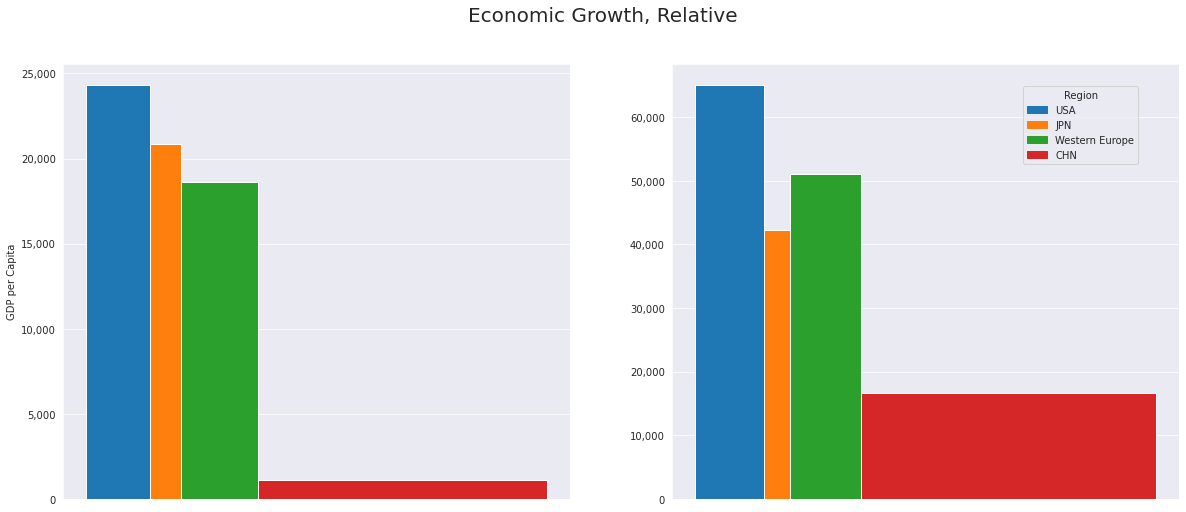

In [137]:
with sns.axes_style("dark"):
    fig, (ax_start, ax_end) = plt.subplots(1, 2, figsize=(20,8))
    fig.suptitle('Economic Growth, Relative', fontsize=20)
    colors = sns.color_palette()
    chart_data_start = get_chart_data(gdp, pop, year_start, query_economist, group_economist, sorting={'by': 'GDP per Capita', 'ascending': False})
    regions = chart_data_start['Region']
    sorting_dict = dict(zip(chart_data_start['Region'], chart_data_start['GDP per Capita']))
    chart_data_end = get_chart_data(gdp, pop, year_end, query_economist, group_economist, sorting={'by': 'Region', 'ascending': False, 'key': lambda x: x.map(sorting_dict)})
    ax_start = draw_variable_width_barchart(chart_data_start, 'GDP per Capita', 'Population', 'Region', ax_start, colors, None, 'GDP per Capita')
    ax_end = draw_variable_width_barchart(chart_data_end, 'GDP per Capita', 'Population', 'Region', ax_end, colors)
    for ax in [ax_start, ax_end]:
        ax.tick_params(axis='x', labelbottom=False)
    patches = [Patch(color=v, label=k) for k, v in zip(regions, colors)]
    fig.legend(title='Region', labels=regions.to_list(), handles=patches, loc='upper right', bbox_to_anchor=(.875, 0.85, 0., 0.))
    

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_axes_internal',
 '_agg_filter',
 '_align_xlabel_grp',
 '_align_ylabel_grp',
 '_alpha',
 '_animated',
 '_axobservers',
 '_axstack',
 '_cachedRenderer',
 '_clipon',
 '_clippath',
 '_constrained',
 '_constrained_layout_pads',
 '_contains',
 '_default_contains',
 '_dpi',
 '_gci',
 '_get_clipping_extent_bbox',
 '_get_dpi',
 '_gid',
 '_gridspecs',
 '_in_layout',
 '_label',
 '_layoutbox',
 '_make_key',
 '_mouseover',
 '_normalize_grid_string',
 '_oid',
 '_path_effects',
 '_picker',
 '_process_projection_requirements',
 '_propobservers',
 '_rasterized',
 '_remove_method',
 '_repr_html_',
 '

## Add More Countries

In [301]:
query_economist_with_more = '`Country Code`.isin(["USA", "JPN", "CHN", "FRA", "DEU", "GBR", "AUT", "ESP", "LUX", "ITA", "IRL", "SAS", "CAD", "AUS", "NZL", "DNK", "SWE", "NOR", "FIN", "RUS"])'
def group_economist_with_more(country_code: str) -> str:
    if country_code in ["FRA", "DEU", "GBR", "AUT", "ESP", "LUX", "ITA", "IRL"]:
        return "WEU"
    elif country_code in ["CAD", "AUS", "NZL"]:
        return "CANZ"
    elif country_code in ["TUR", "ISR"]:
        return "NE"
    elif country_code in ["DNK", "SWE", "NOR", "FIN"]:
        return "BAL"
    else:
        return country_code

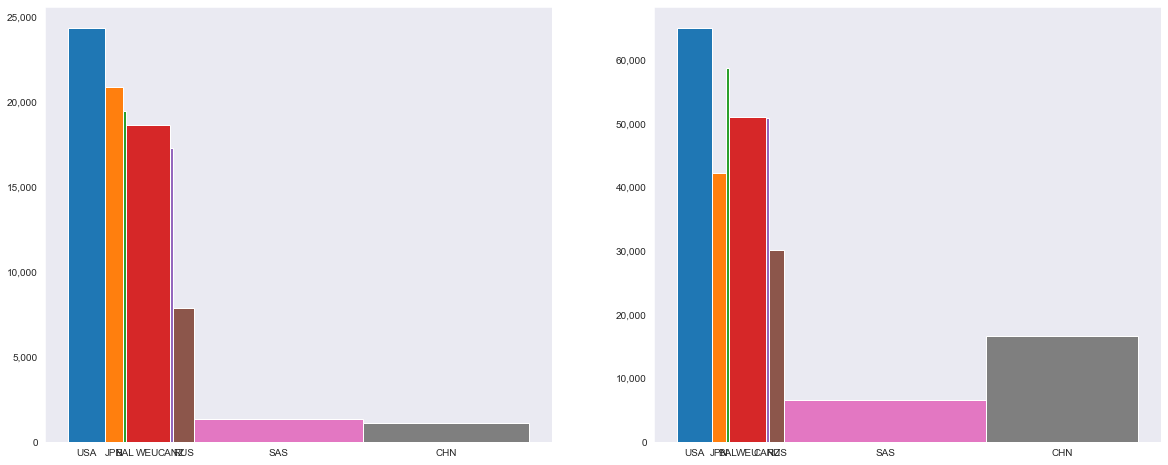

In [302]:
with sns.axes_style("dark"):
    fig, (ax_start, ax_end) = plt.subplots(1, 2, figsize=(20,8))
    chart_data_start = get_chart_data(gdp, pop, year_start, query_economist_with_more, group_economist_with_more, sorting={'by': 'GDP per Capita', 'ascending': False})
    sorting_dict = dict(zip(chart_data_start['Region'], chart_data_start['GDP per Capita']))
    chart_data_end = get_chart_data(gdp, pop, year_end, query_economist_with_more, group_economist_with_more, sorting={'by': 'Region', 'ascending': False, 'key': lambda x: x.map(sorting_dict)})
    draw_variable_width_barchart(chart_data_start, 'GDP per Capita', 'Population', 'Region', ax_start)
    draw_variable_width_barchart(chart_data_end, 'GDP per Capita', 'Population', 'Region', ax_end)
    

In [331]:
world_bank_data[['Country Name', 'Country Code']].sample(5)

,Country Name,Country Code
230,European Union,EUU
743,Vietnam,VNM
109,Latvia,LVA
409,Niger,NER
702,Sierra Leone,SLE


In [233]:
Baltic: DNK SWE NOR FIN
Balkan SVK SVN BGR SRB XKX
Eastern Europe LVA EST MDA CZE HUN POL EST
Central Asian TKM UZB MNG
South Asian: BGD IND

SyntaxError: invalid syntax (<ipython-input-233-f006c6566dbc>, line 3)

In [332]:
query_regions = '`Country Code`.isin(["TSS", "SAS", "LCN", "EUU"])'
def group_default(country_code: str) -> str:
    return country_code

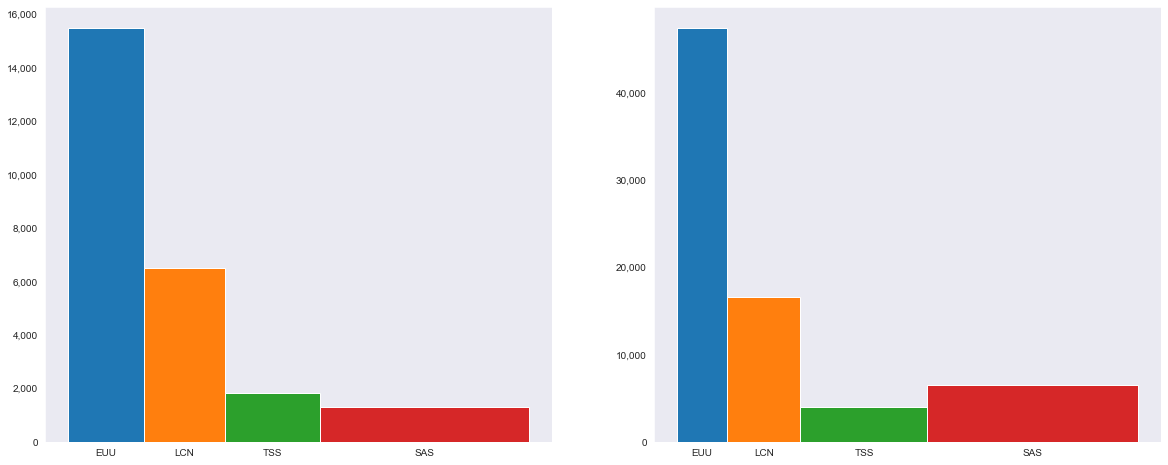

In [333]:
with sns.axes_style("dark"):
    fig, (ax_start, ax_end) = plt.subplots(1, 2, figsize=(20,8))
    chart_data_start = get_chart_data(gdp, pop, year_start, query_regions, group_default, sorting={'by': 'GDP per Capita', 'ascending': False})
    sorting_dict = dict(zip(chart_data_start['Region'], chart_data_start['GDP per Capita']))
    chart_data_end = get_chart_data(gdp, pop, year_end, query_regions, group_default, sorting={'by': 'Region', 'ascending': False, 'key': lambda x: x.map(sorting_dict)})
    draw_variable_width_barchart(chart_data_start, 'GDP per Capita', 'Population', 'Region', ax_start)
    draw_variable_width_barchart(chart_data_end, 'GDP per Capita', 'Population', 'Region', ax_end)
    